   ## Import libraries

In [1]:
import sys
import os

# Import local libs
module_path = os.path.abspath(os.path.join('.', 'libs'))
if module_path not in sys.path:
    sys.path.append(module_path)
from s3utils import *
from rooftop import *

# %load_ext autoreload
# %autoreload 2

/Users/colinbrust/projects/rooftop-index/venv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


   ## 1. Set variables and parameters

In [2]:
# Paths and file names
bucket_name = 'roof-index'
main_dir = 'missoula/geospatial/'  # Main directory to read and write from in S3 bucket.
dsm_fname = 'downtown_dsm.tif'
hfdem_fname = 'downtown_hfdem.tif'
bldgs_fname = 'downtown_bldgs.zip'
bldgs_id = 'fid'  # Name of the unique id used in the buildings shapefile 
slope_fname = 'test_slope.tif'  # Does not exist. This is the name of the file to be written.
height_fname = 'test_height.tif'  # Does not exist. This is the name of the file to be written.
flat_area_fname = 'test_flat_area_bldgs.zip'  # Does not exist. This the name of the file to be written.

# Parameters
pitch_slope_threshold = 11  # Max. slope (degrees) to which we consider roof to be flat.
pitch_area_threshold = 9  # Min. percentage of flat area on a roof to be classified as flat.
fa_slope_threshold = 45  # Max. value of slope for flat area disaggregation
fa_area_threshold = 93.903  # Min. area in m^2 for flat area disaggregation


   ## 3. Instantiate S3 and Rooftop objects

In [3]:
S3 = S3Helper(bucket_name)
Rooftop = RooftopProc(S3, main_dir, dsm_fname, hfdem_fname, bldgs_fname, bldgs_id)

   ## 4. Create slope and height arrays and upload to S3 as geotiffs

In [4]:
slope_arr = Rooftop.create_slope_arr(slope_fname) 
height_arr = Rooftop.create_height_arr(height_fname)

test_slope.tif has been successfully written to your S3 bucket.
test_height.tif has been successfully written to your S3 bucket.


   ## 5. Filter out pitched roofs from bldgs dataframe

In [5]:
flat_bldgs = Rooftop.pitched_roof_filter(pitch_area_threshold, pitch_area_threshold)

/Users/colinbrust/projects/rooftop-index/venv/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1097: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


   ## 6. Disaggregate building footprints into flat areas

In [6]:
disagg_bldgs = Rooftop.flat_area_disaggregator(flat_bldgs, fa_slope_threshold, fa_area_threshold, flat_area_fname)

Creating polygons from raster data. Hang on, this may take a bit.
test_flat_area_bldgs.zip has been successfully written to your S3 bucket.


   ## 7. Add rooftop features
 Features list below can include:

 - 'average_slope'
 - 'height'
 - 'parapet'
 - 'closeness_to_points'
 - 'volume_on_roof'

In [7]:
features = ['average_slope', 'height', 'parapet', 'closeness_to_pts', 'volume_on_roof']
ctp_paths = ['test_greenspaces.zip', 'test_groceries.zip']
full_features = Rooftop.feature_builder(disagg_bldgs, features, ctp_paths=ctp_paths)

Adding average slope feature now.
Adding median height feature now.
Adding parapet feature now.
Adding closeness to test_greenspaces feature now.
Adding closeness to test_groceries feature now.
Adding volume on roof feature now.


   ## 8. Create index

In [8]:
import matplotlib.pyplot as plt

wts = [(1/7) * 2, 1/7, (1/7) / 2, (1/7) / 2, (1/7) / 2, (1/7) / 2, (1/7) * 2]
mcda = Rooftop.index_builder(full_features, wts)
ax = mcda.plot(column="vulnerability", cmap='OrRd', legend=True, figsize=[20,20], edgecolor='k', linewidth=0.5)
ax.set_title('Rank')
ax.axis('off')
# index = mcda[['flat_area', 'avg_slope', 'height', 'parapet_slope', 'test_greenspaces', 'test_groceries', 'volume']]
# mcda['index'] = index.sum(axis=1)
# mcda = mcda.sort_values('index', ignore_index=True)
# mcda['rank'] = range(len(mcda))

# fig, ax = plt.subplots(1, 1, figsize=(20, 20))
# mcda.plot(column='rank', legend=True, ax=ax)
# mcda.to_file('/Users/colinbrust/Desktop/mcda_index.shp')

KeyError: "None of [Index([       ('flat_area', False),         ('avg_slope', True),\n                 ('height', False),     ('parapet_slope', True),\n       ('test_greenspaces', False),   ('test_groceries', False),\n                 ('volume', False)],\n      dtype='object')] are in the [columns]"

In [17]:
mcda = full_features.copy()
geom = mcda['geometry']

mcda = mcda.set_index('faid')
mcda = mcda[[x[0] for x in Rooftop.col_names]]

for cname, inv in Rooftop.col_names:
    mcda[cname] = Rooftop.rescale(mcda[cname], inv)

mcda = mcda.rank(method='min')
crit = [MIN] * len(mcda.columns)

if not wts:
    wts = [1/len(mcda.columns)] * len(mcda.columns)

mca_data = Data(mcda.values, crit, anames=mcda.index, cnames=mcda.columns, weights=wts)

dm = closeness.TOPSIS()
dec = dm.decide(mca_data)
mcda['vulnerability'] = dec.e_.closeness
mcda['vul_rank'] = dec.rank_
mcda['geometry'] = geom
x = gpd.GeoDataFrame(mcda)


,flat_area,avg_slope,height,parapet_slope,test_greenspaces,test_groceries,volume,vulnerability,vul_rank,geometry
faid,,,,,,,,,,
0,175.0,246.0,263.0,210.0,362.0,137.0,1.0,0.669384,157,"POLYGON ((257154.883 300139.913, 257154.883 30..."
1,224.0,267.0,320.0,210.0,368.0,163.0,278.0,0.343242,296,"POLYGON ((257117.393 300148.142, 257117.393 30..."
2,140.0,292.0,168.0,210.0,358.0,145.0,1.0,0.689610,142,"POLYGON ((257127.418 300168.259, 257128.366 30..."
3,246.0,16.0,39.0,350.0,329.0,82.0,255.0,0.429940,270,"POLYGON ((257148.482 300256.956, 257146.654 30..."
4,214.0,70.0,357.0,225.0,334.0,71.0,282.0,0.404273,275,"POLYGON ((257430.118 300142.656, 257431.032 30..."
...,...,...,...,...,...,...,...,...,...,...
382,70.0,243.0,251.0,201.0,249.0,204.0,1.0,0.755571,75,"POLYGON ((258006.190 301247.251, 258006.190 30..."
383,262.0,254.0,60.0,332.0,258.0,236.0,1.0,0.601537,199,"POLYGON ((258047.027 301300.033, 258048.039 30..."
384,254.0,348.0,59.0,332.0,259.0,237.0,1.0,0.588818,210,"POLYGON ((258033.622 301306.687, 258033.622 30..."


(1/7) * 2

(257004.19124187258, 258583.64620790037, 300048.2575861493, 301702.56990697596)

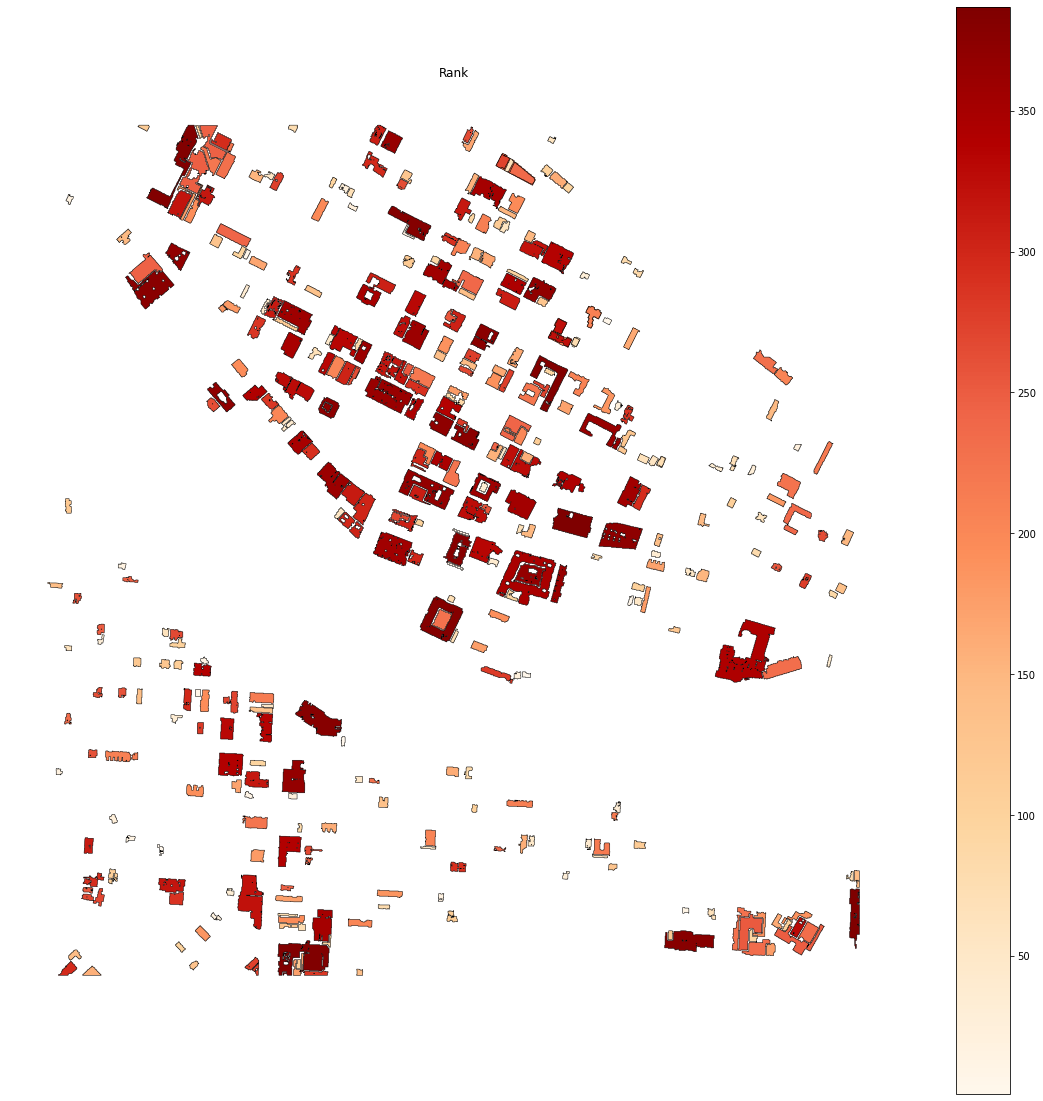

In [18]:
ax = x.plot(column="vul_rank", cmap='OrRd', legend=True, figsize=[20,20], edgecolor='k', linewidth=0.5)
ax.set_title('Rank')
ax.axis('off')